In [1]:
import torch

In [2]:
cd '/home/animesh/Desktop/Research Project/MANNSuite/Matrix-NTM'

/home/animesh/Desktop/Research Project/MANNSuite/Matrix-NTM


In [3]:
MNTM = torch.load('./SavedModels/MatNTM_MatCopy1/INP5_5_HID30_30_MD50_6_6_Adam4CE_Copy50000/MNTM.pth')

In [4]:
import matplotlib.pyplot as plt

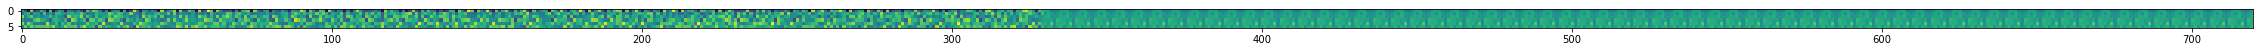

In [5]:
batch_num = 0
plt.figure(figsize=(40,24))
plt.imshow( torch.cat([MNTM.MemoryUnit.Memory.detach().cpu()[batch_num][i] for i  in range(120)], dim = 1) )

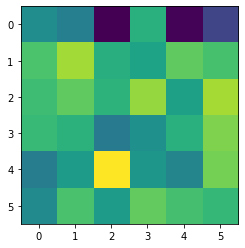

In [6]:
plt.imshow(MNTM.Prev_Read_Matrices[0][0].detach().cpu())

In [7]:

def MatrixCopyDataGen(batch_size = 32, item_size = [4,5], timesteps = 2, device = None):
    
    assert item_size[0] == item_size[1] - 1
    
    pre_content = torch.rand([batch_size, item_size[0]+1, item_size[1]*timesteps])
    
    pre_content[:,:-1,:][pre_content[:,:-1,:] > 0.5] = 1.0
    pre_content[:,-1,:] = 0.0
    pre_content[pre_content != 1] = 0.0
        
    limiter = torch.zeros([batch_size, item_size[0]+1, item_size[1]])
    limiter[:,-1,:] = 1.0
    #response_sheet = torch.zeros_like(pre_content)
    
    
    question = torch.cat([pre_content, limiter], dim = 2)
    
    return question.to(device), pre_content.to(device)





def Bit_Seq_Error(output , target):
    bit_output = output.detach().clone()
    bit_output[bit_output >= 0.5] = 1.0
    bit_output[bit_output != 1.0] = 0.0

    mean_bit_error = torch.mean(torch.abs(output - bit_output))

    return mean_bit_error

loss_func = torch.nn.BCELoss()


In [9]:
i=0
num_t = 100

inp, out = MatrixCopyDataGen(32,[4,5],num_t, 'cuda:0')

response_sheet = torch.zeros_like(out)

print("Epoch: ",i)

print("--->Sequence Length: ",int(num_t))

MNTM.HiddenReset()

MNTM.zero_grad()



#Feeding the sequence
for t in range(1,num_t+2):
    _ = MNTM(inp[:,:,(t-1)*5:t*5])

#Taking Output from controller now, for backprop
output = []

for t in range(1,num_t+1):
    MNTM_out = MNTM(response_sheet[:,:,(t-1)*5:t*5])
    output.append(MNTM_out)


res = torch.cat(output, dim=2)

loss = loss_func(res, out)


print("----->Loss: {}".format(loss))
print("\n---------->Validation Loss on Sequence Length {} : {}\n".format(num_t,loss))
print('Bit Sequence Error : {}'.format(Bit_Seq_Error(res, out)))

Epoch:  0
--->Sequence Length:  100
----->Loss: 0.0019094048766419291

---------->Validation Loss on Sequence Length 100 : 0.0019094048766419291

Bit Sequence Error : 0.0014256179565563798


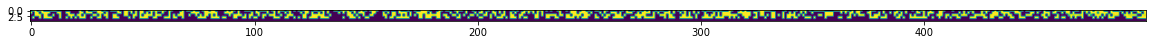

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(res[0].detach().cpu())

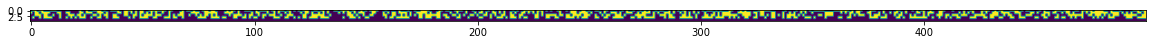

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(out[0].detach().cpu())

In [2]:

def OneBatchSequence(seq_size = [4,5], item_size = 2, num_items = 15, query_num = 14):
    
    assert num_items > query_num
    
    limiter = torch.zeros([seq_size[0]+1, seq_size[1]])
    limiter[-1,0] = 1.0
    limiter[-1,-1] = 1.0
    
    
    cat_list = []
    for i in range(num_items):
        
        cat_list.append(limiter)
        
        content = torch.rand([seq_size[0]+1, seq_size[1] * item_size])
        content[:-1,:][content[:-1,:] > 0.5] = 1.0
        content[-1,:] = 0.0
        content[content != 1] = 0.0
        cat_list.append(content)
        
    
    delimeter = torch.zeros([seq_size[0]+1, seq_size[1]])
    delimeter[-1,1:-1] = 1.0
    cat_list.append(delimeter)
    
    
    start = seq_size[1]*query_num + (query_num - 1)*(seq_size[1]*2)
    stop = seq_size[1]*query_num + (query_num - 1)*(seq_size[1]*2) + (seq_size[1]*2) 
    
    sequence = torch.cat(cat_list, dim = 1)
    
    query = sequence[:,start:stop]
    expected_result = sequence[:,start+3*seq_size[1] : stop+3*seq_size[1]]

    
    finalsequence = torch.cat([sequence, query], dim = 1)
            
    
    return finalsequence, expected_result




def GenRandBatchSeq(batch_size=32, seq_size = [4,5], item_size = 2, num_items = 15, device = None):
    
    seq_list = []
    res_list = []
    
    
    
    for i in range(batch_size):
        query_num = torch.randint(low=1, high=num_items, size=[])
        seq, res = OneBatchSequence(seq_size=seq_size, item_size=item_size, num_items=num_items, query_num=query_num)
        seq_list.append(seq.unsqueeze(0))
        res_list.append(res.unsqueeze(0))
    
    seq_tensor = torch.cat(seq_list, dim=0)
    res_tensor = torch.cat(res_list, dim=0)
    
    return seq_tensor.to(device), res_tensor.to(device)


In [16]:
x,y = GenRandBatchSeq(num_items=7)

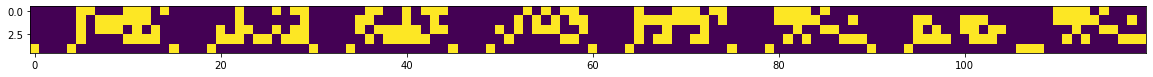

In [23]:
plt.figure(figsize=(20,12))
plt.imshow(x[9])

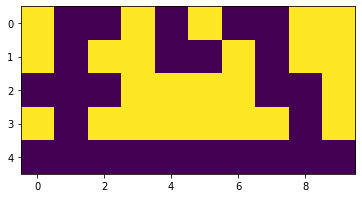

In [22]:
plt.imshow(y[0])